Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time

Layers, Network and FUnction construction

Activation Functions

In [3]:
class noon:
    def activate(self, input):
        return input
    def grad(self, input):
        return 1
class sigmoidActivation:
    def activate(self, input):
        return 1 / (1 + np.exp(-input))
    def grad(self,input):
        sig = self.activate(input)
        return sig*(1-sig)


class reluActivation:
    def activate(self, input):
        return np.maximum(0,input)
    def grad(self,input):
        input[input<=0] = 0
        input[input>0] = 1
        return input

Cost Functions

In [4]:
#Loss Functions
class basicLoss:
    def activate(self,y_t,y_pred):
        y = y_pred-y_t
        y=np.sum(y**2)
        return y
    def grad(self,y_t,y_pred):
        y = y_pred-y_t
        y = y*2
        return y
#regression
def MSE(y_t, y_pred):
    return np.mean(np.power(y_t-y_pred,2))
#classification
class crossEntropyLoss:
    def activate(self,y_t, y_pred):
        self.old_x = y_pred.clip(min=1e-8,max=None)
        self.old_y = y_t
        return np.where(y_pred==1,-np.log(self.old_x), 0)
    def grad(self,y_t, y_pred):
        out = np.where(self.old_y==1,-1/self.old_x, 0)
        return out

Network\
-Implemented by splitting components into classes, computationally inefficient but easier to read.

In [90]:
class Layer:
    def __init__(self, numIn, numOut, activation=noon()):
        '''
            Initiate the Layer and variables to store relevant information.
            Likely stores too much information and is not efficient.
        '''
        self.numIn = numIn
        self.numOut = numOut
        self.weights = np.random.rand(numIn,numOut)
        self.biases = np.atleast_2d(np.zeros(numOut))
        self.activation = activation

        self.input = np.zeros(numIn)
        self.weightedout = np.zeros(numOut)
        self.out = np.zeros(numOut)

        self.costGradW = np.random.rand(numIn,numOut)
        self.costGradB = np.random.rand(numOut)

    def forward(self, inputs):
        weightedInputs = np.dot(inputs,self.weights)
        out = weightedInputs + self.biases
        self.weightedout = out
        if self.activation:
            out = self.activation.activate(out)
        
        self.out = out
        self.input = inputs
        return out

    def applyGrad(self, lr):
        
        self.weights -= lr * self.costGradW
        self.biases -= lr * self.costGradB

    
    def backward(self,grad):
        '''
            Backward calculations of a single layer, calculates
            the gradient of the weights w.r.t the cost of the 
            network as a whole. Returns gradient of cost w.r.t
            the input for the next layer.
        '''
        inp = np.atleast_2d(self.input)
        grad = np.atleast_2d(grad)
        
        dact = np.atleast_2d(self.activation.grad(self.weightedout))
        grad = dact*grad
        
        self.costGradB = np.atleast_2d(grad).mean(axis=0)
        self.costGradW = np.matmul(inp.T,grad).mean(axis=0)

        return np.dot(grad,self.weights.T)



class Network:
    def __init__(self,layers=[], lossFunction=basicLoss(), lr=0.001):
        self.layers=layers
        self.loss=None
        self.lossFunction = lossFunction
        self.lr = lr
        
    def forward_pass(self, inputs):
        for Layer in self.layers:
            inputs = Layer.forward(inputs)
        
        return np.atleast_2d(inputs)

    def classify(self, inputs):
        output = self.forward_pass(inputs)
        return np.argmax(output)

    def backprob(self,y_t,y_pred):
        '''
            This function takes the target and network predictions and performs 
            backpropagation by looping backward through the layers and calling 
            the backward function of the given layer. Grad is the running
            gradient of the network required for the next layers calculations.
        '''
        grad = self.lossFunction.grad(y_t,y_pred)
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)
        
        for l in range(len(self.layers)-1,-1,-1):
            self.layers[l].applyGrad(self.lr)

    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        out = np.mean(predictions)
        return out


    def learn(self,input ,expected):
        #change btw classify and forward_pass
        out = self.forward_pass(input)
        
        loss = self.lossFunction.activate(expected,out)
        self.backprob(expected,out)

    def train(self,x_train,y_train,xval=None,yval=None,epochs=500, batchSize=1):
        for iter in range(epochs):
            for i in range(0,len(y_train)-1,batchSize):
                
                if i+batchSize < len(y_train):
                    x = x_train[i:i+batchSize,:]
                    y = y_train[i:i+batchSize,:]
                else:
                    x = x_train[i:-1,:]
                    y = y_train[i:-1,:]
                out = self.forward_pass(x)
                
                self.backprob(y,out)
            if iter%10==0:
                    out = self.forward_pass(x_train)
                    print(self.compute_accuracy(x_train,y_train))


In [70]:
loss=basicLoss()
sig = sigmoidActivation()
Layer1 = Layer(2,5)
Layer2 = Layer(5,3,sig)
Layero = Layer(3,2,sig)

network = Network([Layer1,Layer2,Layero])

testinput = np.array([2,2])

#x = network.forward_pass(testinput)
#x

tx = [0.5,0.5]

network.learn(testinput,tx)

Data Exploration and Formatting

In [100]:


sig = sigmoidActivation()
relu = reluActivation()
data = pd.read_csv('train.csv')
data

y_t = data[['Survived']]


test_train = data[['Pclass','Sex']].copy()
test_train['Sex'] = test_train['Sex'].map({'male':0, 'female':1})
y_t.value_counts()

#plt.scatter(data.Sex,data.Pclass,s=20,c=data.Survived,cmap='Greens')


Survived
0           549
1           342
dtype: int64

In [ ]:
sig = sigmoidActivation()
relu = reluActivation()
basic = basicLoss()

Layer1 = Layer(2,3)
Layero = Layer(3,1,sig)
train = test_train.to_numpy()
net = Network([Layer1,Layero],lossFunction=basic,lr=0.003)

y = y_t.to_numpy()

pre_score = 0
for i in range(len(y)):
    pred = net.forward_pass(train[i])
    
    pre_score+= np.sum(np.abs(pred-y[i]))
    
print(net.layers[0].weights)
print(net.layers[1].weights)
print(pre_score)

for k in range(1000):
    for j in range(len(y)):
        net.learn(train[j],y[j])

post_score = 0
pred_sum=0
for l in range(len(y)):
    pred = net.forward_pass(train[l])
    
    pred_sum+=pred
    post_score+= np.sum(np.abs(pred-y[l]))

print(net.layers[0].weights)
print(net.layers[1].weights)
print(pred_sum)
print(post_score)

In [105]:
np.random.seed(seed=0)

sig = sigmoidActivation()
relu = reluActivation()
basic = basicLoss()
Layer1 = Layer(2,3)
Layer2 = Layer(3,3)
Layer3 = Layer(4,3)
Layero = Layer(3,2,sig)

net = Network([Layer1,Layer2,Layero],lossFunction=basic,lr=0.001)

train = test_train.to_numpy()
y = y_t.to_numpy()
y2 = y.copy()
y[y2==1]=0
y[y2==0]=1
expected = np.squeeze(np.array([y,y2])).T

net.train(train,expected,epochs=500,batchSize=50)



0.3838383838383838
0.6161616161616161
0.6161616161616161
0.6161616161616161
0.6161616161616161
0.6161616161616161
0.6161616161616161
0.6161616161616161
0.6161616161616161
0.6161616161616161
0.6161616161616161
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7867564534231201
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816
0.7149270482603816


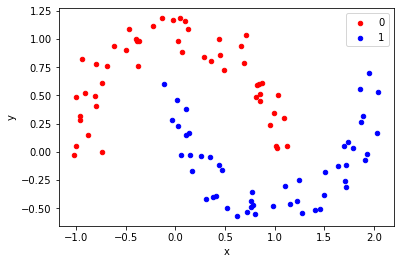

In [96]:

from sklearn.datasets import make_moons
from matplotlib import pyplot
from pandas import DataFrame
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.1)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()
y2 = y.copy()
y[y2==1]=0
y[y2==0]=1
expected = np.squeeze(np.array([y,y2])).T

In [99]:
sig = sigmoidActivation()
relu = reluActivation()
basic = basicLoss()
np.random.seed(seed=0)

Layer1 = Layer(2,3)
Layer2=Layer(3,3,sig)
Layer3=Layer(3,3,sig)
Layero = Layer(3,2,sig)

net = Network([Layer1,Layer2,Layer3,Layero],lossFunction=basic,lr=0.05)

net.train(X,expected,epochs=2000,batchSize=2)

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.53
0.56
0.58
0.61
0.62
0.65
0.65
0.65
0.64
0.63
0.62
0.6
0.58
0.61
0.61
0.61
0.61
0.65
0.65
0.68
0.7
0.72
0.71
0.71
0.72
0.71
0.71
0.69
0.68
0.67
0.66
0.64
0.65
0.65
0.65
0.65
0.65
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.65
0.64
0.64
0.65
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.67
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.67
0.67
0.67
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.69
0.69
0.69
0.69
0.69
0.69
0.69
0.69
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
